# Packing and influence on cell motility

Some time ago Hadrien Mary [@Hadim_](https://twitter.com/Hadim_) asked me if tyssue could reproduce this work:

<blockquote class="twitter-tweet" data-lang="fr"><p lang="en" dir="ltr">The subtle mechanics of densely packed cells may help explain why some cancerous tumors stay put while others spread <a href="https://t.co/G6lbhLhQxQ">https://t.co/G6lbhLhQxQ</a> <a href="https://t.co/AK9SzzUazU">pic.twitter.com/AK9SzzUazU</a></p>&mdash; Quanta Magazine (@QuantaMagazine) <a href="https://twitter.com/QuantaMagazine/status/907371443025039361?ref_src=twsrc%5Etfw">11 septembre 2017</a></blockquote>
<script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>



![Cellular traffic jam](../data/gif/cellular_traffic_jam.gif)


The relevant model is described in [Mapeng Bi et al.](https://arxiv.org/abs/1409.0593v4)

The master equation is the following:

$$\epsilon = \sum_\alpha \left[ (a_\alpha - 1)^2 + \frac{(p_\alpha - p_0)^2}{r}\right]$$

With a unit prefered area and $p_\alpha$ the cell perimeter.

In [1]:
from tyssue import config, Sheet, PlanarGeometry
from tyssue.solvers.sheet_vertex_solver import Solver
from tyssue.draw.plt_draw import quick_edge_draw

sheet = Sheet.planar_sheet_2d('jam', 15, 15, 1, 1, noise=0.2)
PlanarGeometry.update_all(sheet)

sheet.remove(sheet.cut_out([[0, 10], [0, 10]]))
sheet.sanitize()
PlanarGeometry.scale(sheet, sheet.face_df.area.mean()**-0.5, ['x', 'y'])
PlanarGeometry.update_all(sheet)
sheet.reset_index()
sheet.reset_topo()
fig, ax = quick_edge_draw(sheet)

In [3]:
from tyssue.dynamics.factory import model_factory
from tyssue.dynamics import effectors, units
from tyssue.utils import to_nd
from tyssue.utils.testing import effector_tester, model_tester

class PermiterElasticity(effectors.AbstractEffector):

    dimensions = units.line_elasticity
    magnitude = 'perimeter_elasticity'
    label = 'Perimeter Elasticity'
    element = 'face'
    specs = {
        'face': {
            'is_alive',
            'perimeter',
            'perimeter_elasticity',
            'prefered_perimeter'
            }
        }

    spatial_ref = 'prefered_perimeter', units.length

    @staticmethod
    def energy(eptm):
        return eptm.face_df.eval('0.5 * is_alive'
                                 '* perimeter_elasticity'
                                 '* (perimeter - prefered_perimeter)** 2')

    @staticmethod
    def gradient(eptm):

        gamma_ = eptm.face_df.eval(
            'perimeter_elasticity * is_alive'
            '*  (perimeter - prefered_perimeter)')
        gamma = eptm.upcast_face(gamma_)

        grad_srce = - eptm.edge_df[eptm.ucoords] * to_nd(gamma,
                                                         len(eptm.coords))
        grad_srce.columns = ['g'+u for u in eptm.coords]
        grad_trgt = - grad_srce
        return grad_srce, grad_trgt

    
    
    
model = model_factory(
    [PermiterElasticity,
     effectors.FaceAreaElasticity],
    effectors.FaceAreaElasticity)

model_specs = {
    'face': {
        'area_elasticity': 1.,
        'prefered_area': 1.,
        'perimeter_elasticity': 0.1, # 1/2r in the master equation
        'prefered_perimeter': 3.8,
        },
     'edge': {'ux': 0, 'uy': 0}
}
    


sheet.update_specs(model_specs)


effector_tester(sheet, effectors.FaceAreaElasticity)
model_tester(sheet, model)

res = Solver.find_energy_min(sheet, PlanarGeometry, model)

print(res.message)

b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


In [4]:
sheet.face_df.perimeter.mean()

3.7994845469004614

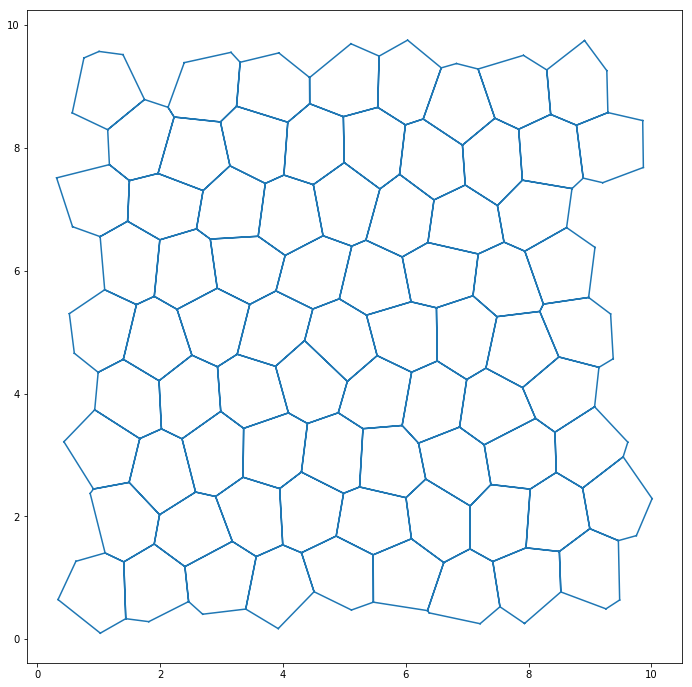

In [5]:
fig, ax = quick_edge_draw(sheet)
fig.set_size_inches(12, 12)

In [62]:
sheet.edge_df.length.mean()

0.6350612193484438